In [ ]:
import os
import pathlib
import time
import zipfile
import tarfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

2024-05-05 20:48:59.286798: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 20:48:59.411467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 20:48:59.411512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 20:48:59.416880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 20:48:59.431268: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
#!unzip -o ./tf_data_additional_4.zip;


Archive:  ./tf_data_additional_4.zip
   creating: tf_data_additional/
  inflating: tf_data_additional/.DS_Store  
  inflating: __MACOSX/tf_data_additional/._.DS_Store  
   creating: tf_data_additional/test_data/
   creating: tf_data_additional/train_data/
   creating: tf_data_additional/validation_data/
  inflating: tf_data_additional/species_encoding.pkl  
   creating: tf_data_additional/test_data/12073845064448163246/
  inflating: tf_data_additional/test_data/.DS_Store  
  inflating: __MACOSX/tf_data_additional/test_data/._.DS_Store  
  inflating: tf_data_additional/test_data/snapshot.metadata  
  inflating: tf_data_additional/test_data/dataset_spec.pb  
  inflating: tf_data_additional/train_data/.DS_Store  
  inflating: __MACOSX/tf_data_additional/train_data/._.DS_Store  
  inflating: tf_data_additional/train_data/snapshot.metadata  
  inflating: tf_data_additional/train_data/dataset_spec.pb  
   creating: tf_data_additional/train_data/7620346648989953827/
  inflating: tf_data_addit

In [ ]:
# !rm -rf ./tf_data_additional

In [ ]:
working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)


In [ ]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2024-05-05 20:52:39.200034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 20:52:39.245602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 20:52:39.248572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
df = pd.read_csv('data/undersampled_top_10.csv')
X = []
y = []
df_efficient = df.set_index('catalogNumber')
df_efficient.head(5)

,Unnamed: 0,gbifID,references,basisOfRecord,sex,lifeStage,behavior,eventTime,month,continent,countryCode,verbatimElevation,decimalLatitude,decimalLongitude,mediaType,genus,species
catalogNumber,,,,,,,,,,,,,,,,,
XC361568,117,2243757996,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,flight call,6:07:00 PM,3.0,EUROPE,DE,260 m,48.9870,9.0108,Sound;StillImage;StillImage,Loxia,Loxia curvirostra
XC361676,122,2243757192,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,5:30:00 PM,3.0,EUROPE,GR,40 m,36.8217,21.9273,StillImage;StillImage;Sound,Sylvia,Sylvia atricapilla
XC361991,137,3909408313,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,10:00:00 AM,3.0,EUROPE,NL,0 m,52.3568,4.5675,StillImage;StillImage;Sound,Fringilla,Fringilla coelebs
XC362620,162,2243759376,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, sweeoo call",2:27:00 PM,4.0,EUROPE,DE,300 m,49.0102,8.8949,Sound;StillImage;StillImage,Phylloscopus,Phylloscopus collybita
XC363724,205,2243761271,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, imitation",7:30:00 AM,4.0,EUROPE,PL,160 m,53.1490,20.2591,Sound;StillImage;StillImage,Parus,Parus major


In [ ]:
test_dataset = tf.data.Dataset.load('tf_data_additional/test_data')
train_dataset = tf.data.Dataset.load('tf_data_additional/train_data')
val_dataset = tf.data.Dataset.load('tf_data_additional/validation_data')


In [ ]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return {'image_input': normalize_image(img['image_input']), 'feature_input': img['feature_input']}, label

print(train_dataset.take(1))

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

<_TakeDataset element_spec=({'image_input': TensorSpec(shape=(128, 431), dtype=tf.uint8, name=None), 'feature_input': TensorSpec(shape=(5,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float32, name=None))>


In [ ]:
input_img = tf.keras.Input((128, 431, 1), name='image_input')
first_conv = Conv2D(80, kernel_size=(125, 6), padding='same')(input_img)
first_rlu = LeakyReLU(alpha=0.3)(first_conv)
first_pool = MaxPooling2D(pool_size=(4, 6))(first_rlu)
second_conv = Conv2D(160, kernel_size=(1, 2), padding='same')(first_pool)
second_rlu = LeakyReLU(alpha=0.3)(second_conv)
second_pool = MaxPooling2D(pool_size=(1, 2))(second_rlu)
third_conv = Conv2D(240, kernel_size=(1, 2), padding='same')(second_pool)
third_rlu = LeakyReLU(alpha=0.3)(third_conv)
third_pool =  MaxPooling2D(pool_size=(1, 2))(third_rlu)
fourth_conv = Conv2D(320, kernel_size=(1, 2), padding='same')(third_pool)
fourth_rlu = LeakyReLU(alpha=0.3)(fourth_conv)
fourth_pool =  MaxPooling2D(pool_size=(1, 2))(fourth_rlu)
flatten = Flatten()(fourth_pool)
dropout = Dropout(0.5)(flatten)
input_features = tf.keras.Input(5, name='feature_input')
dense3 = Dense(100, activation='relu')(input_features)
dense6 = Dense(100, activation='relu')(dense3)
dropout3 = Dropout(0.5)(dense6)
dense4 = Dense(100, activation='relu')(dropout3)
dense5 = Dense(100, activation='relu')(dense4)
dropout4 = Dropout(0.5)(dense5)
concat = tf.keras.layers.Concatenate()([dropout, dropout4])
output= Dense(10, activation='softmax', kernel_regularizer=L2(0.001))(concat)

Piczak_model_2 = Model(inputs =[input_img, input_features], outputs=output)

Piczak_model_2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 128, 431, 1)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 128, 431, 80)         60080     ['image_input[0][0]']         
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)  (None, 128, 431, 80)         0         ['conv2d_24[0][0]']           
                                                                                                  
 max_pooling2d_24 (MaxPooli  (None, 32, 71, 80)           0         ['leaky_re_lu_24[0][0]']      
 ng2D)                                                                                      

In order to handle the additional features in the input (latitude, longitude, elevation, month, isHUmanObservation), we set up a separate FFN that takes in as input the 5 features; this architecture runs in parallel to the convolutional neural net. The FFN has 4 dense layers with relu activations and 100 nodes each; there are two dropout layers with p=0.5 to avoid overfitting to the training data. We then concatenate the output of the last dense layer to the output of the head of the baseline CNN. The resulting vector is passed into the output layer, which has the sigmoid activation.

In [ ]:
Piczak_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=3)
history = Piczak_model_2.fit(train_dataset, epochs=20, validation_data = val_dataset, callbacks=[es])


Epoch 1/20
2303/2303 [==============================] - 573s 247ms/step - loss: 1.2680 - accuracy: 0.6519 - val_loss: 1.0354 - val_accuracy: 0.7560
Epoch 2/20
2303/2303 [==============================] - 569s 247ms/step - loss: 1.0359 - accuracy: 0.7607 - val_loss: 0.9704 - val_accuracy: 0.7867
Epoch 3/20
2303/2303 [==============================] - 570s 248ms/step - loss: 0.9785 - accuracy: 0.7839 - val_loss: 0.9312 - val_accuracy: 0.8103
Epoch 4/20
2303/2303 [==============================] - 572s 248ms/step - loss: 0.9498 - accuracy: 0.7991 - val_loss: 0.9112 - val_accuracy: 0.8222
Epoch 5/20
2303/2303 [==============================] - 572s 248ms/step - loss: 0.9360 - accuracy: 0.8093 - val_loss: 0.9221 - val_accuracy: 0.8235
Epoch 6/20
2303/2303 [==============================] - 571s 248ms/step - loss: 0.9350 - accuracy: 0.8152 - val_loss: 0.9012 - val_accuracy: 0.8346
Epoch 7/20
2303/2303 [==============================] - 571s 248ms/step - loss: 0.9287 - accuracy: 0.8207 - val_

In [ ]:
Piczak_model_2.save_weights('other_features.h5')
with open('other_features', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [ ]:
def plot_hist(model, title=None):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(model.history['loss'], label='train')
    axs[0].plot(model.history['val_loss'], label='val')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('CE Loss')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(model.history['accuracy'], label='train')
    axs[1].plot(model.history['val_accuracy'], label='val')
    axs[1].set_title('Accuracy')
    axs[1].legend();
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)

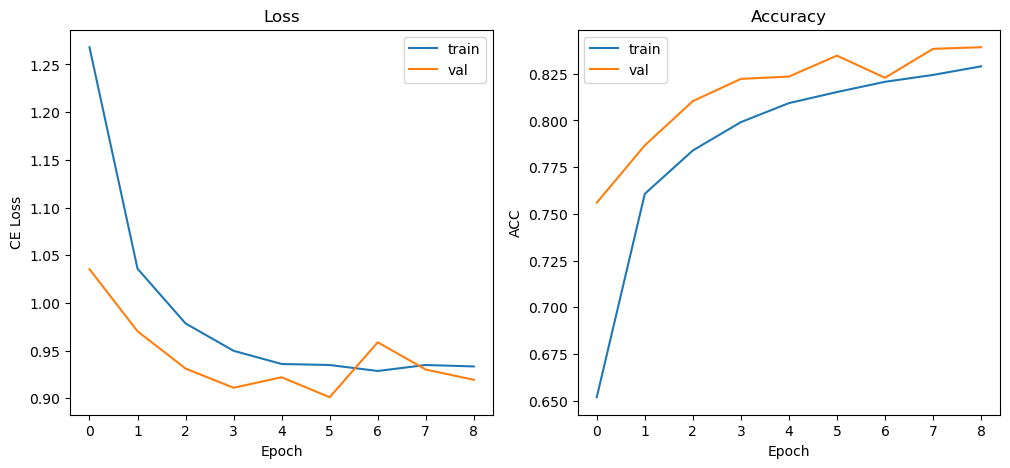

In [ ]:
plot_hist(history)

We can see that the model overfits around epoch 5, and our accuracy reaches around 0.83-0.84. This is better performance than our baseline model and smaller kernel models on the validation sets.

In [ ]:
test_loss, test_accuracy = Piczak_model_2.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

720/720 [==============================] - 86s 120ms/step - loss: 0.9146 - accuracy: 0.8400
Test Loss: 0.9145896434783936
Test Accuracy: 0.840006947517395


This model performs better on the test dataset when compared to the purely convolutional models. As expected, the addition of more features gives some boost to the model's performance, with around a 4% accuracy increase. This is not much of a boost, so likely experimenting with different ways of combining the features with the convolutional networks could lead to better model performance.